In [11]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализаций
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [12]:
# 1. Загрузка набора данных
df = pd.read_csv('data/MSPUS.csv', parse_dates=['observation_date'], index_col='observation_date')
df.sort_index(inplace=True)
df.head()

,MSPUS
observation_date,
1963-01-01,17800
1963-04-01,18000
1963-07-01,17900
1963-10-01,18500
1964-01-01,18500


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 1963-01-01 to 2024-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   MSPUS   248 non-null    int64
dtypes: int64(1)
memory usage: 3.9 KB
None

Описательная статистика:
               MSPUS
count     248.000000
mean   156114.112903
std    115951.319546
min     17800.000000
25%     55900.000000
50%    128350.000000
75%    235375.000000
max    442600.000000


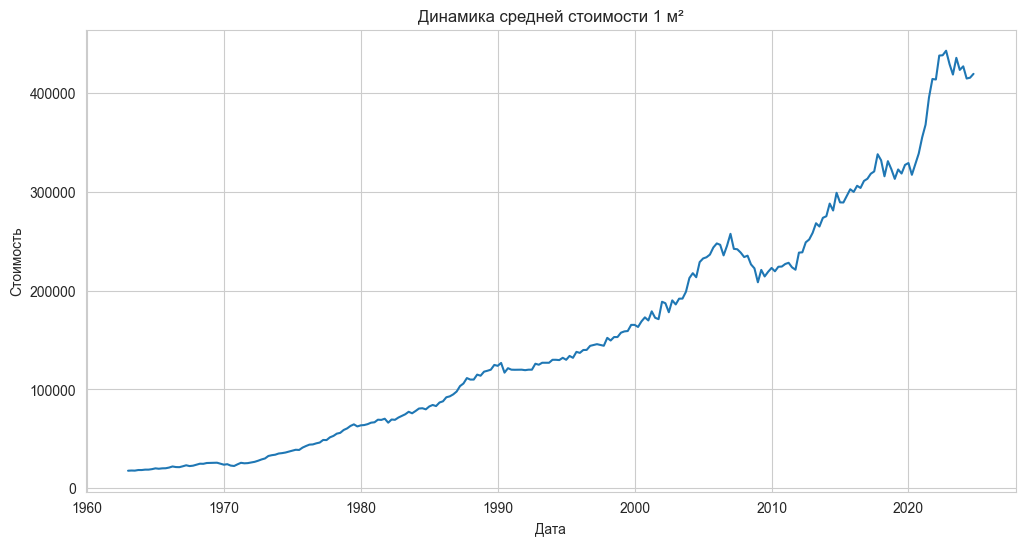


Пропуски в данных:
MSPUS    0
dtype: int64


In [13]:
# 2. Исследование данных
print("Информация о данных:")
print(df.info())
print("\nОписательная статистика:")
print(df.describe())

# Визуализация временного ряда
plt.plot(df.index, df['MSPUS'])
plt.title('Динамика средней стоимости 1 м²')
plt.xlabel('Дата')
plt.ylabel('Стоимость')
plt.show()

# Проверка на пропуски
print("\nПропуски в данных:")
print(df.isnull().sum())

In [14]:
# 3. Предварительная обработка данных
# Проверка стационарности с помощью теста Дики-Фулера
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

test_stationarity(df['MSPUS'])

# Если ряд не стационарен, применим дифференцирование
df_diff = df.diff().dropna()
test_stationarity(df_diff['MSPUS'])

ADF Statistic: 2.885509994536555
p-value: 1.0
Critical Values: {'1%': np.float64(-3.458731141928624), '5%': np.float64(-2.8740258764297293), '10%': np.float64(-2.5734243167124093)}
ADF Statistic: -2.761773017762323
p-value: 0.06394509282063833
Critical Values: {'1%': np.float64(-3.459105583381277), '5%': np.float64(-2.8741898504150574), '10%': np.float64(-2.5735117958412097)}


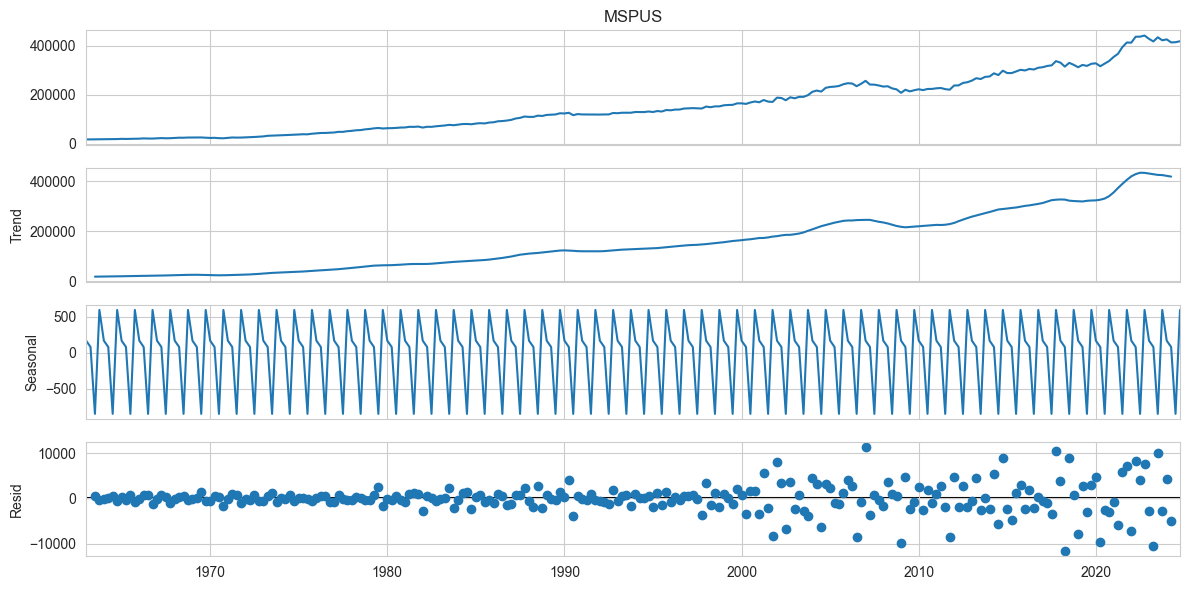

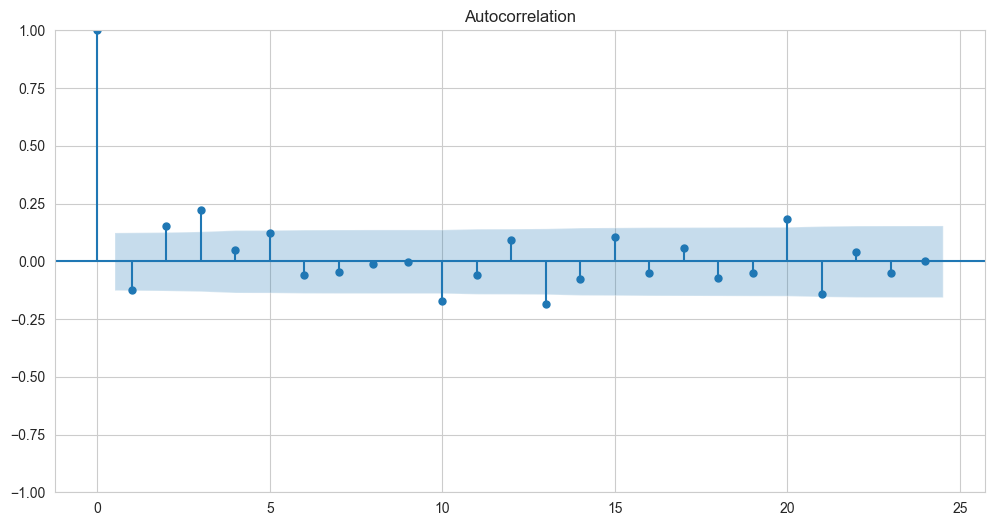

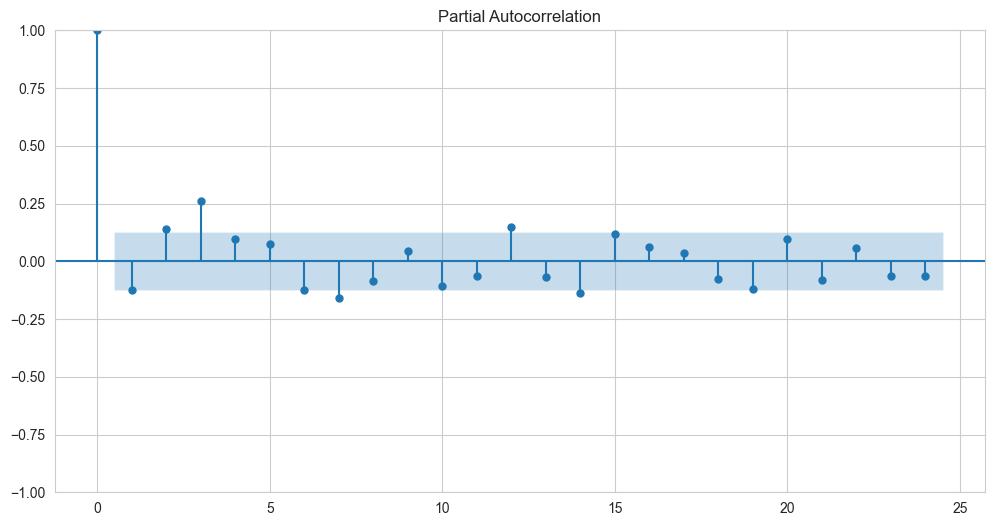

In [15]:
# Декомпозиция временного ряда
decomposition = seasonal_decompose(df['MSPUS'], model='additive', period=4)
decomposition.plot()
plt.show()

# ACF и PACF для определения параметров ARIMA
plot_acf(df_diff)
plot_pacf(df_diff)
plt.show()

In [16]:
# 4-5. Выбор методов и метрик
# Методы: SARIMA, Prophet
# Метрики: RMSE, MAE (обоснование: чувствительность к ошибкам прогноза)

# Разделение данных на train/test (80/20)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [18]:
# 6-7. Обучение и оценка моделей

# SARIMA
def evaluate_sarima(train, test, order, seasonal_order):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    return rmse, mae

# Примеры параметров (подбираются через grid search)
sarima_params = [
    ((1,1,1), (1,1,1,4)),
    ((2,1,2), (1,1,1,4))
]

for param in sarima_params:
    rmse, mae = evaluate_sarima(train['MSPUS'], test['MSPUS'], *param)
    print(f'SARIMA{param} RMSE: {rmse:.2f}, MAE: {mae:.2f}')

# Prophet
def evaluate_prophet(train, test):
    df_train = train.reset_index().rename(columns={'observation_date': 'ds', 'MSPUS': 'y'})
    model = Prophet()
    model.fit(df_train)
    future = model.make_future_dataframe(periods=len(test), freq='Q')
    forecast = model.predict(future)
    preds = forecast.iloc[-len(test):]['yhat']
    rmse = np.sqrt(mean_squared_error(test['MSPUS'], preds))
    mae = mean_absolute_error(test['MSPUS'], preds)
    return rmse, mae

rmse_p, mae_p = evaluate_prophet(train, test)
print(f'Prophet RMSE: {rmse_p:.2f}, MAE: {mae_p:.2f}')

SARIMA((1, 1, 1), (1, 1, 1, 4)) RMSE: 80205.76, MAE: 68682.80


14:45:48 - cmdstanpy - INFO - Chain [1] start processing


SARIMA((2, 1, 2), (1, 1, 1, 4)) RMSE: 75036.28, MAE: 63414.69


14:45:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 60172.51, MAE: 47509.55


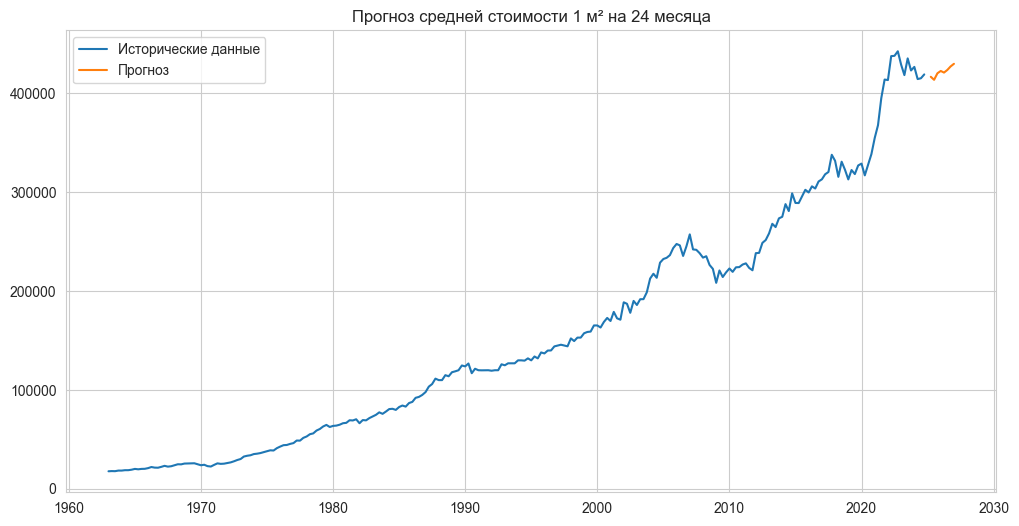

In [19]:
# 8. Прогнозирование лучшей моделью
# Предположим, SARIMA(2,1,2)x(1,1,1,4) показала лучшие результаты
best_model = SARIMAX(df['MSPUS'], order=(2,1,2), seasonal_order=(1,1,1,4))
best_model_fit = best_model.fit(disp=False)
forecast = best_model_fit.forecast(steps=8)  # 24 месяца = 8 кварталов

# Визуализация прогноза
plt.plot(df.index, df['MSPUS'], label='Исторические данные')
plt.plot(pd.date_range(df.index[-1], periods=9, freq='Q')[1:], forecast, label='Прогноз')
plt.title('Прогноз средней стоимости 1 м² на 24 месяца')
plt.legend()
plt.show()